In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: van Gastel, Rob (1387952)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

I slowly increased the size and amount of layers within reasonable range until no improvements based on score were gained. Also, different optimization methods were tested Adagrad and SGD gave the best results. As activation function Leaky ReLu was used, as this performed better and prevents the 'dead neuron' problem of ReLu. The score obtained on validation is 85%, but we can still see a large deviation between the validation and training accuracy in the plot. (length: 466)



Max val score: 85.55%


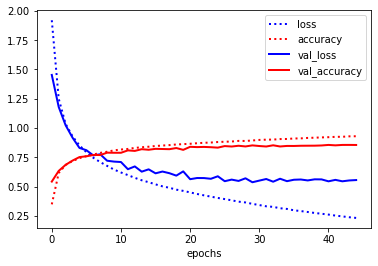

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 3072)              0         


_________________________________________________________________
dense_16 (Dense)             (None, 2048)              6293504   
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                5130      
Total params: 8,921,610
Trainable params: 8,921,610
Non-trainable params: 0

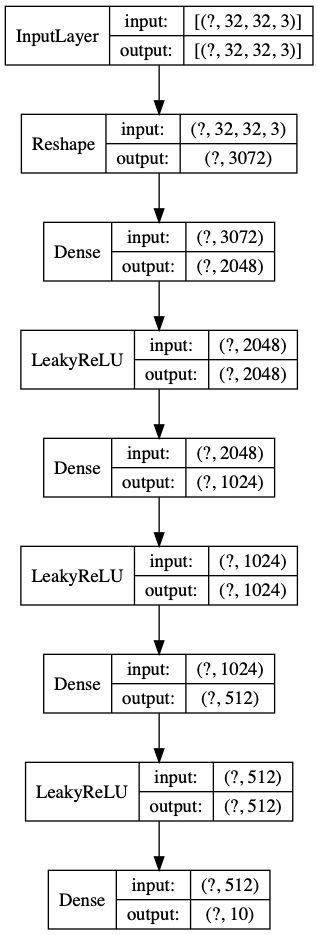

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

Preprocessing the images creates less input parameters, namely the colour channels. Which don't seem to be necessary for classification of the numbers. Removing these dimensions by the greyscale conversion makes for less input parameters making the model less complex. Also, reduce in size of the training data reduces the computational cost of the model. These are improvements on the model. As it has approximately the same score as model 1.1. (length: 446)



Max val score: 85.96%


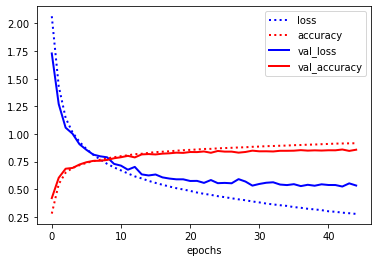

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 2048)              2099200   
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 2048)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 512)              

def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(2048))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.Dense(10, activation='softmax'))
    # adag = optimizers.Adagrad(lr=0.1) # or
    sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

When applying Bias, Kernel, activity -regularization the model converged slower or not at all. Using Dropout layers had a lot of effect on the difference between training and validation score. Dropout performed better with a higher learning rate of 0.01, a dropout rate of 0.1, a batch size of 64 and 45 epochs. About 2% accuracy score is gained on the validation set, but the model still overfits the training data. (length: 417)



Max val score: 87.27%


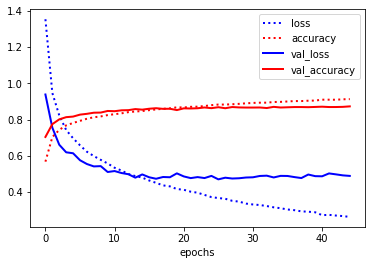

def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(2048))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(10, activation='softmax'))
    # adag = optimizers.Adagrad(lr=0.1) # or
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

I retained the same activation functions as in Q1, as this performed better than ReLu, TanH and sigmoid. I slowly expanded on different layers structures of convolutional layers. Applying at least 2 convolutional layers followed by max pooling, like the VGG model, led to an increase in accuracy. These convolutional layers are followed by 2 dense layers. Using regular ReLu on the convolutional layers, improved the model. After this batch normalization and dropout layers were applied as regularization. Based on testing different architectures I mobtained current model. This resulted in the model converging faster and a closer training and validation score. The model performs about 10% better than the models of Q1, with 95% accuracy. (length: 741)



Max val score: 95.37%


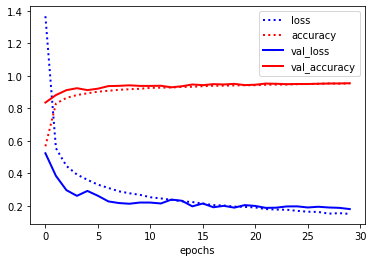

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
dropout_13 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)      

def build_model_2_1():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))    
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))    
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))    
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))    
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))    
    model.

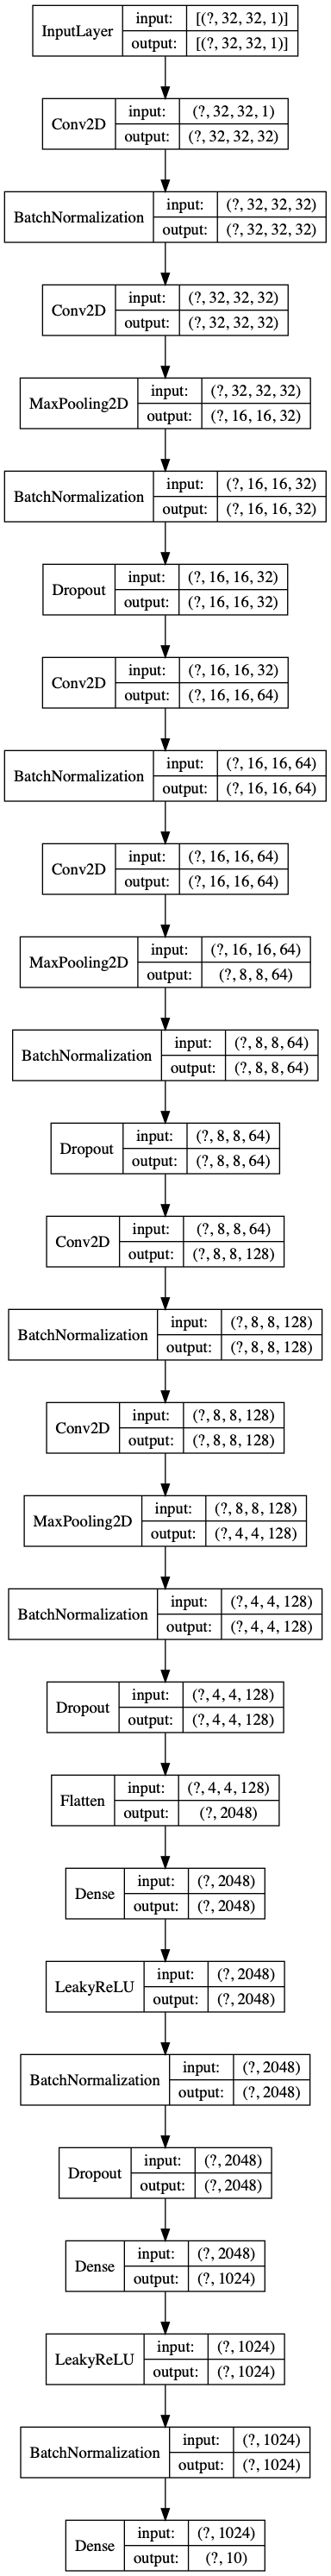

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

If the model performed well on the training (while using the augmented data) the validation score would usually be higher than the training score and converge faster. Techniques that didn't perform well, brightness, large zooms and vertical /horizontal flips. Techniques that perform well, small rotations (30 degrees), applying a shear, a small zoom and width/height shifting. The most benefit was observed when combining the techniques. We gain about 0.5% accuracy compared to model 2.1. (length: 490)



Max val score: 95.57%


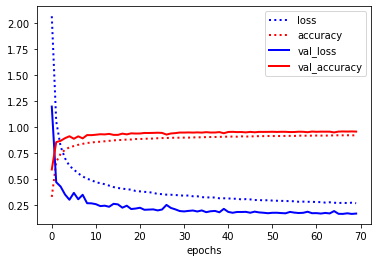


train_data_gen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest',
)


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

An accuracy score of 95.6% is obtained on the test data. The class that has the most miss classifications is label 1. With most cases misclassifying it for 0 and 7. Most of these false predictions are categorized as label 1. Looking at the mistakes made in the misclassifications plot for label 1. Mistakes that are observed in this plot are, images wrongly labelled were the actual label doesn't correspond to the y label e.g. mistake in the dataset, images with a lot of noise such as blurry pictures and other symbols in the same picture and images with multiple numbers in the image where predicting one of the other numbers in the image is a miss classification. (length: 668)

Test score: 0.96%


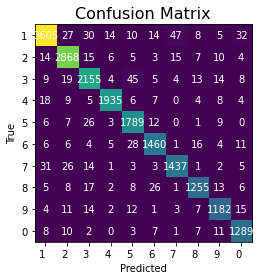

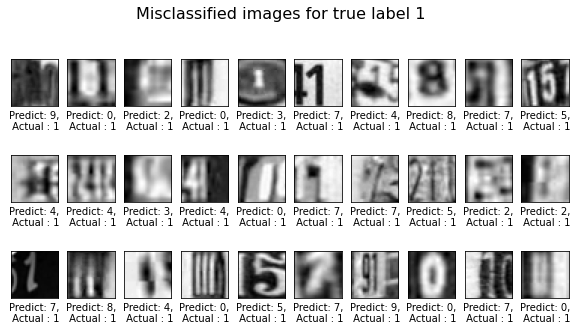

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

In the first layer we see a lot of purple parts which dont seem to activate the 8 and 5. In the second layer we can see more clearly that in most cases the contour of 8 is highlighted. Especially the second layer we see most images being yellow colored for 8. The layers 3 and 4 seem to highlight certain patterns within the image like vertical edges. The deeper we go into the layers the lower the resolution gets and abstracter the patterns become. In the laste 2 layers it becomes hard to see by the human eye which features the convolutional layers use to classify the image. (length: 580)



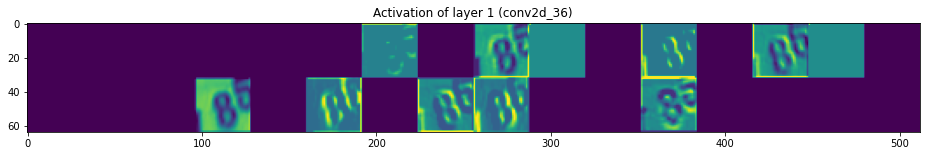

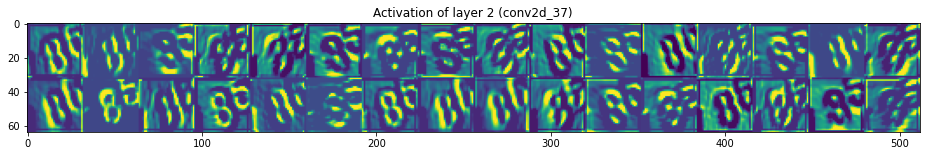

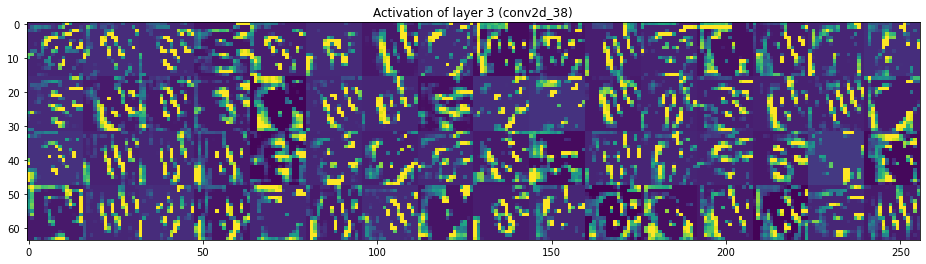

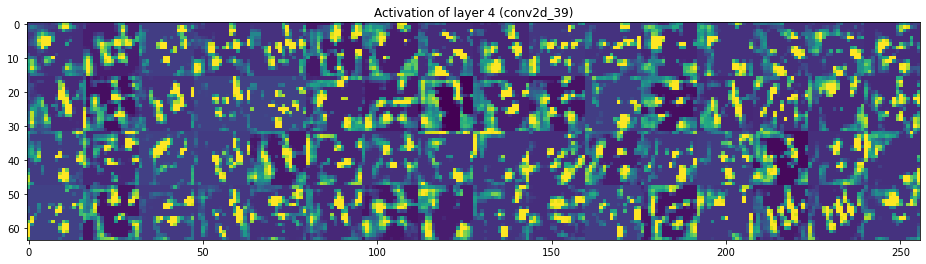

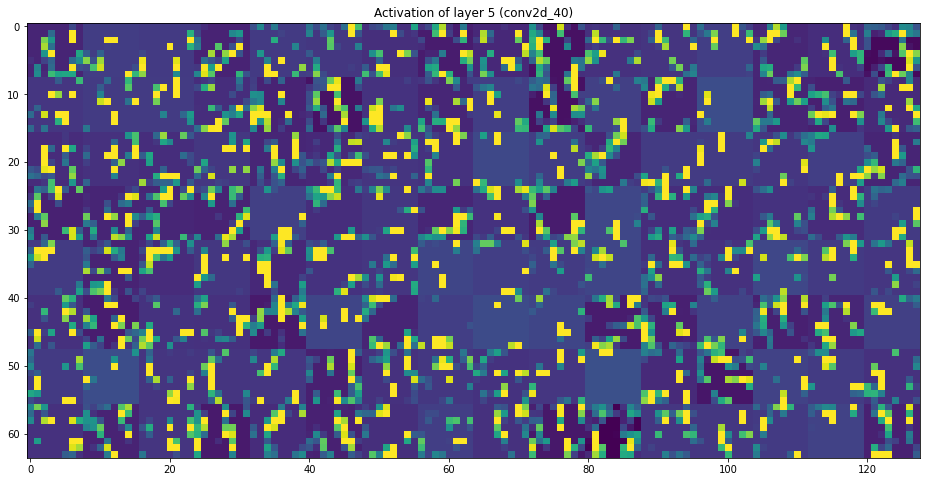

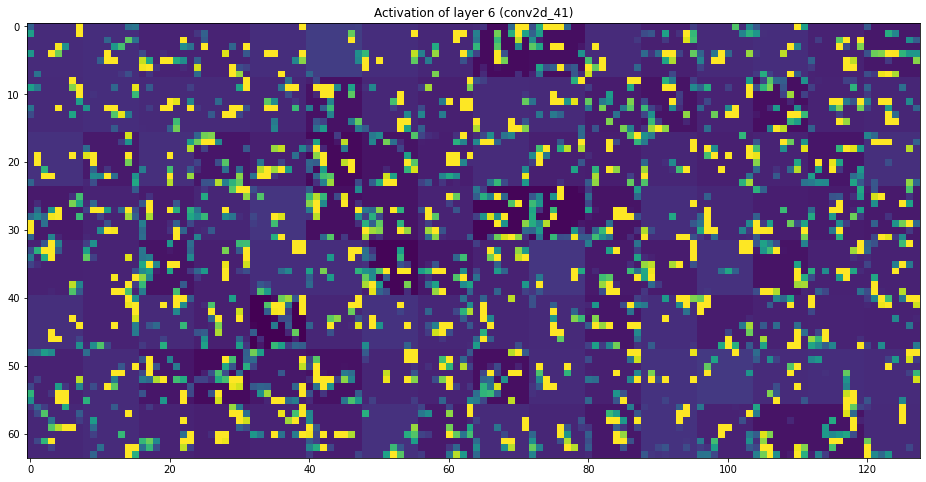

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

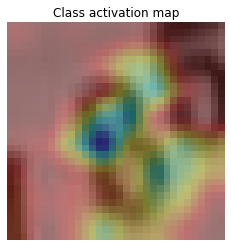

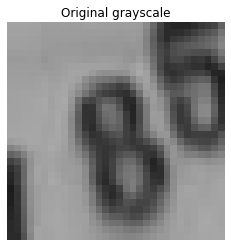

def plot_activation_map():
    # Example as seen in the slides about CNN
    K.clear_session()
    tf.compat.v1.disable_eager_execution()
    
    x_sample, y_sample = X_test[0], y_test[0]
    x_sample = rgb2gray(np.expand_dims(x_sample, axis=0))

    model = load_model_from_file(base_dir, "model_2_2")
    preds = model.predict(x_sample)
    
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    
    last_conv_layer  = model.get_layer("conv2d_41")
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x_sample])
    
    for i in range(128):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
        
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    image = np.concatenate((x_sam

In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

Using the VGG16 as base model, a lot of different observations were made.Training the model without unfreezing any or few layers resulted in a low accuracy score. Iteratively unlocking more layers the accuracy score went up.As the model should be fine-tuned on the data a smaller learning rate of 1e-4 is picked, such that the original information of the layers is not destroyed. The best result was obtained freezing the first 8 layers with a validation accuracy score of 93% using augmentation. (length: 497)



Max val score: 93.09%


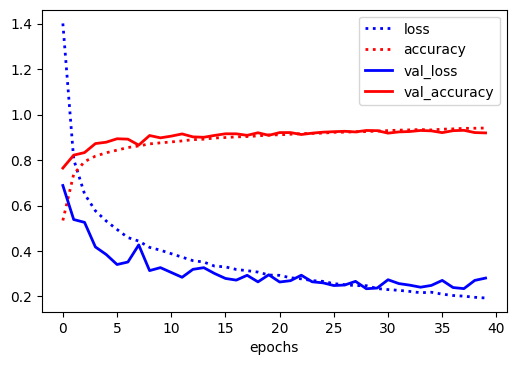

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout_14 (Dropout)         (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 2048)              1050624   
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 2048)              0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout_15 (Dropout)         (None, 2048)            

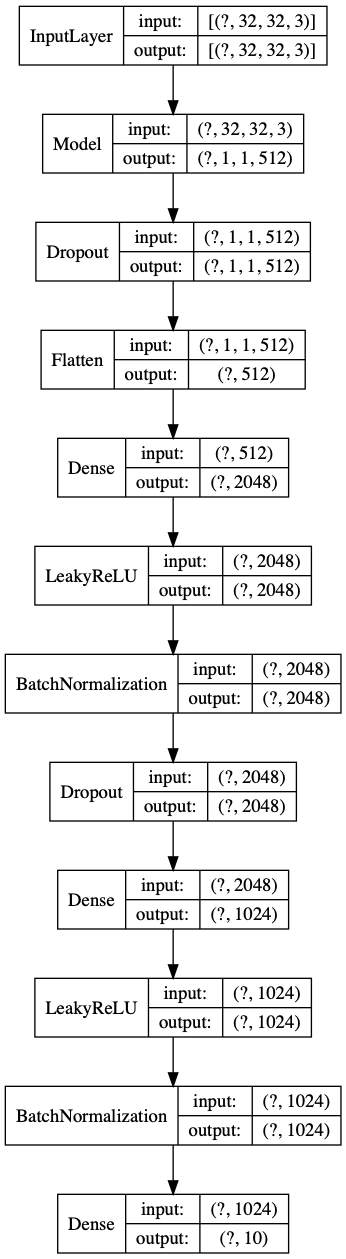

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

The algorithms attempted to are logistic regression, SVM, Adaboost and RandomForest. PCA was used to reduce size of the embeddings and running times. Grid search was used to find good parameters. Algorithms suggested by the paper (linked in the notebook) SVM and kNN, performed well during model selection. The best score obtained on model selection was 93% accuracy and 92% on the test set, by SVM. This is the same score as model_4_1. I wasnt able to beat most scores of previous models. (length: 490)

Pipeline(steps=[('reshape',
                 FunctionTransformer(func=<function transform_embedding at 0x23aeff620>)),
                ('reduce_dim', PCA(n_components=0.98)),
                ('clf', SVC(C=0.0464158883, gamma=0.000244140625))])
def store_embeddings():
    """ Stores all necessary embeddings to file
    """
    model_name = "model_4_1"
    model = load_model_from_file(base_dir, model_name).layers[0]
    names = ["train", "val", "test"]
    X_set = [X_train, X_val, X_test]
   

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 22.74 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
